In [2]:
import pandas as pd
import numpy as np
import random
import jieba
import jieba.posseg as pseg
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']

In [3]:
all_data = pd.read_excel('C:\\Users\WENDY\\Desktop\\消费者行为分析\\课业2019\\消费贷款数据.xlsx')
# 替换nan为0
#all_data.where(all_data.notnull(), 0)
all_data = all_data.fillna(0)

columns_name = all_data.columns.tolist()
columns_name

['公司名称',
 '城市',
 '贷款金额',
 '期限',
 '月供',
 '还款总费用',
 '月管理费',
 '期限最低范围',
 '期限最高范围',
 '还款方式',
 '放款日期',
 '审批时间',
 '担保方式',
 '申请人数',
 '申请条件']

In [4]:
all_data.head()

,公司名称,城市,贷款金额,期限,月供,还款总费用,月管理费,期限最低范围,期限最高范围,还款方式,放款日期,审批时间,担保方式,申请人数,申请条件
0,中腾信金融信息服务（上海）有限公司北京分公司,北京,10万元,12月,9225,1.07,月管理费 1.60%,1,12,分期还款,1,1.0,信用贷,198,北京牌照车辆、全款车、购买三个月以上1、名下有北京牌照车辆2、全款车、购买三个月以上3、信用...
1,北京森强国际投资担保有限公司,北京,10万元,12月,10046,2.06,月管理费 3.00%,1,120,到期还款,1,1.0,抵押贷,44,名下有车、北京牌照、有稳定还款来源1、名下有车2、北京牌照3、有稳定还款来源温馨提示：名下有...
2,北京博瑞奕华投资有限公司,北京,10万元,12月,9333,1.20,参考月利率 1.00%,1,36,分期还款,3,1.0,信用贷,308,中国合法公民、18-60周岁、信用良好1、中国合法公民2、年龄在18-60岁3、具有完全民事...
3,北京博瑞奕华投资有限公司,北京,10万元,12月,8885,1.06,参考月利率 1.00%,1,12,到期还款,15,10.0,抵押贷,0,1、公司五证2、个人信息材料3、公司往来合同4、银行流水5、财务报表6、资产证明
4,北京中金行投资管理有限公司,北京,10万元,12月,9749,1.70,月管理费 2.50%,1,36,分期还款,1,1.0,抵押贷,0,1、身份证、户口本2、结婚证3、收入证明、房产证明或资产证明等


In [5]:
columns_num = [ '月供', '还款总费用', '期限最低范围',
               '期限最高范围',  '放款日期', '审批时间']

columns_nonnum = ['城市', '还款方式', '担保方式', '贷款金额', '期限']

columns_res = ['申请人数']

In [6]:
# 城市 还款方式 担保方式 贷款金额 期限 月管理费
# 当作绝对变量，对于每一个类型进行赋值
def processCate(data_list):
    data_set = list(set(data_list))
    data_dic = {}
    for i in range(len(data_set)):
        data_dic[data_set[i]] = i + 1
    return data_dic


def getNonnumDict(name):
    data_list = all_data[name].tolist()
    data_dict = processCate(data_list)
    return data_dict

In [7]:
# 月管理费
yglf_num = []
yglf_type = []
for i in all_data['月管理费'].tolist():
    i = i.split()
    yglf_type.append(i[0])
    yglf_num.append(float(i[-1][:-1]))

In [8]:
cs_dict = getNonnumDict('城市')
hkfs_dict = getNonnumDict('还款方式')
dbfs_dict = getNonnumDict('担保方式')
dkje_dict = getNonnumDict('贷款金额')
qx_dict = getNonnumDict('期限')
yglf_dict = processCate(yglf_type)

In [9]:
# 得到所有的因变量
# 分类变量计数，目前没有用到
#cs_count = {}
#hkfs_count = {}
#dbfs_count = {}
all_samples = []
all_results = []
g = 0
for row in all_data.itertuples(index = True, name = 'Pandas'):
    all_sample = []
#    cs = getattr(row, '城市')
#    cs_count = getTextDict([cs], cs_count)
#    hkfs = getattr(row, '还款方式')
#    hkfs_count = getTextDict([hkfs], hkfs_count)
#    dbfs = getattr(row, '担保方式')
#    dbfs_count = getTextDict([dbfs], dbfs_count)
    
    for name in columns_num:
        if name == '放款日期':
            if type(getattr(row, name)) != int:
                all_sample.append(4)
            else:
                all_sample.append(getattr(row, name))
        else:
            all_sample.append(getattr(row, name))
    
    all_sample.append(cs_dict[getattr(row, '城市')])
    all_sample.append(hkfs_dict[getattr(row, '还款方式')])
    all_sample.append(dbfs_dict[getattr(row, '担保方式')])
    all_sample.append(dkje_dict[getattr(row, '贷款金额')])
    all_sample.append(qx_dict[getattr(row, '期限')])
    all_sample.append(yglf_dict[yglf_type[g]])
    all_sample.append(yglf_num[g])
    
    all_results.append(getattr(row, '申请人数'))
    
    g = g + 1
    all_samples.append(all_sample)


In [10]:
# 数据标准化
# [0, 1] 标准化是最基本的一种数据标准化方法，指的是将数据压缩到0～1之间
def MaxMinNormalization(x):
    """[0,1] normaliaztion"""
#    print(np.min(x))
#    print(np.max(x))
    #x = (x - np.min(x)) / (np.max(x) - np.min(x))
    
    return x

# Z-score标准化是基于数据均值和方差的标准化化方法。
# 标准化后的数据是均值为0，方差为1的正态分布。
# 这种方法要求原始数据的分布可以近似为高斯分布，否则效果会很差。
def ZscoreNormalization(x):
    """Z-score normaliaztion"""
    x = (x - np.mean(x)) / np.std(x)
    return x

In [11]:
# 多变量回归
# 整合数据
data = {
        '月供':MaxMinNormalization([i[0] for i in all_samples]),
        '还款总费用':MaxMinNormalization([i[1] for i in all_samples]),
        '期限最低范围':MaxMinNormalization([i[2] for i in all_samples]),
        '期限最高范围':MaxMinNormalization([i[3] for i in all_samples]),
        '放款日期':MaxMinNormalization([i[4] for i in all_samples]),
        '审批时间':MaxMinNormalization([i[5] for i in all_samples]),
        '城市':MaxMinNormalization([i[6] for i in all_samples]),
        '还款方式':MaxMinNormalization([i[7] for i in all_samples]),
        '担保方式':MaxMinNormalization([i[8] for i in all_samples]),
        '贷款金额':[i[9] for i in all_samples],
        '期限':[i[10] for i in all_samples],
        '月管理费类型':MaxMinNormalization([i[11] for i in all_samples]),
        '月管理费数额':MaxMinNormalization([i[12] for i in all_samples]),
        '申请人数':[i for i in all_results]
        }


data = pd.DataFrame(data)

In [12]:
all_data.head()


,公司名称,城市,贷款金额,期限,月供,还款总费用,月管理费,期限最低范围,期限最高范围,还款方式,放款日期,审批时间,担保方式,申请人数,申请条件
0,中腾信金融信息服务（上海）有限公司北京分公司,北京,10万元,12月,9225,1.07,月管理费 1.60%,1,12,分期还款,1,1.0,信用贷,198,北京牌照车辆、全款车、购买三个月以上1、名下有北京牌照车辆2、全款车、购买三个月以上3、信用...
1,北京森强国际投资担保有限公司,北京,10万元,12月,10046,2.06,月管理费 3.00%,1,120,到期还款,1,1.0,抵押贷,44,名下有车、北京牌照、有稳定还款来源1、名下有车2、北京牌照3、有稳定还款来源温馨提示：名下有...
2,北京博瑞奕华投资有限公司,北京,10万元,12月,9333,1.20,参考月利率 1.00%,1,36,分期还款,3,1.0,信用贷,308,中国合法公民、18-60周岁、信用良好1、中国合法公民2、年龄在18-60岁3、具有完全民事...
3,北京博瑞奕华投资有限公司,北京,10万元,12月,8885,1.06,参考月利率 1.00%,1,12,到期还款,15,10.0,抵押贷,0,1、公司五证2、个人信息材料3、公司往来合同4、银行流水5、财务报表6、资产证明
4,北京中金行投资管理有限公司,北京,10万元,12月,9749,1.70,月管理费 2.50%,1,36,分期还款,1,1.0,抵押贷,0,1、身份证、户口本2、结婚证3、收入证明、房产证明或资产证明等


In [13]:
# 处理哑变量，不使用之前的词典分类的结果！！

from patsy import dmatrices


In [14]:
fkrq = all_data['放款日期'].values.tolist()
ind = fkrq.index('审批后当日（审批为3')
fkrq[ind] = 4

In [15]:
# 城市 还款方式 担保方式 贷款金额 期限 月管理费

all_data1 = all_data
all_data1['月管理费类型'] = yglf_type
all_data1['月管理费利率']   = yglf_num
all_data1['放款日期']   = fkrq
all_data1['申请人数']   = np.log(all_data1['申请人数'])
all_data1['申请人数'][np.isinf(all_data1['申请人数'])] = 0



y, x = dmatrices("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类型 + 月管理费利率""", data = all_data1, return_type = 'dataframe')

#x['月供']           = all_data['月供']
#x['还款总费用']     = all_data['还款总费用']
#x['期限最低范围']   = all_data['期限最低范围']
#x['期限最高范围']   = all_data['期限最高范围']
#x['放款日期']       = all_data['放款日期']
#x['审批时间']       = all_data['审批时间']
#x['月管理费利率']   = yglf_num


C:\Users\WENDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\WENDY\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
print(y.head())
print(x.head())
print(x.columns)

       申请人数
0  5.288267
1  3.784190
2  5.730100
3  0.000000
4  0.000000
   Intercept  城市[T.北京]  城市[T.南京]  城市[T.天津]  城市[T.广州]  城市[T.成都]  城市[T.杭州]  \
0        1.0       1.0       0.0       0.0       0.0       0.0       0.0   
1        1.0       1.0       0.0       0.0       0.0       0.0       0.0   
2        1.0       1.0       0.0       0.0       0.0       0.0       0.0   
3        1.0       1.0       0.0       0.0       0.0       0.0       0.0   
4        1.0       1.0       0.0       0.0       0.0       0.0       0.0   

   城市[T.济南]  城市[T.深圳]  城市[T.西安]  ...  担保方式[T.自由选]  月管理费类型[T.参考月利率]  \
0       0.0       0.0       0.0  ...          0.0              0.0   
1       0.0       0.0       0.0  ...          0.0              0.0   
2       0.0       0.0       0.0  ...          0.0              1.0   
3       0.0       0.0       0.0  ...          0.0              1.0   
4       0.0       0.0       0.0  ...          0.0              0.0   

   月管理费类型[T.月管理费]       月供  还款总费用  期限最低范围  期限最高范围 

In [17]:
lm_cate = sm.OLS(y, x).fit()
print(lm_cate.summary())

                            OLS Regression Results                            
Dep. Variable:                   申请人数   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.887
Date:                Sun, 24 Nov 2019   Prob (F-statistic):           6.67e-10
Time:                        09:35:05   Log-Likelihood:                -2639.4
No. Observations:                1046   AIC:                             5331.
Df Residuals:                    1020   BIC:                             5460.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -18.8216     15.053     

In [18]:
#进一步检验数据是不是适合使用OLS，
#我们暂且先检验一下数据是否为线性，虚无假设是线性的
#采用Rainbow test

print(sm.stats.linear_rainbow(lm_cate))


(1.0775851359834765, 0.19964787950948887)


In [19]:
names = all_data.columns.tolist()
names


['公司名称',
 '城市',
 '贷款金额',
 '期限',
 '月供',
 '还款总费用',
 '月管理费',
 '期限最低范围',
 '期限最高范围',
 '还款方式',
 '放款日期',
 '审批时间',
 '担保方式',
 '申请人数',
 '申请条件',
 '月管理费类型',
 '月管理费利率']

城市
期限
月供
还款总费用
月管理费
期限最低范围
期限最高范围
还款方式
放款日期
审批时间
担保方式
月管理费类型
月管理费利率


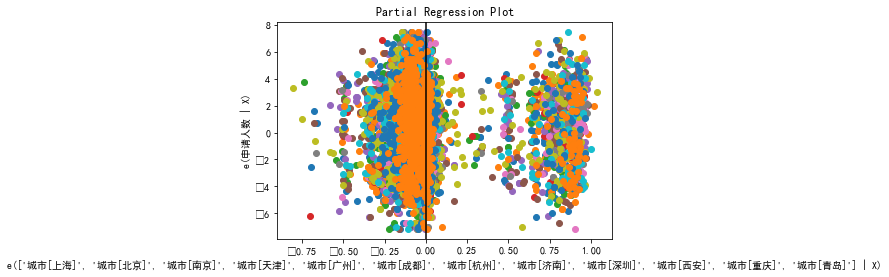

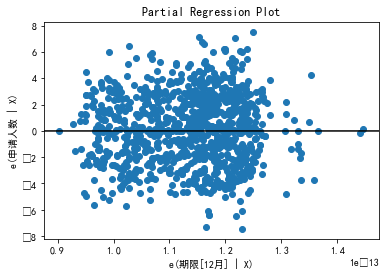

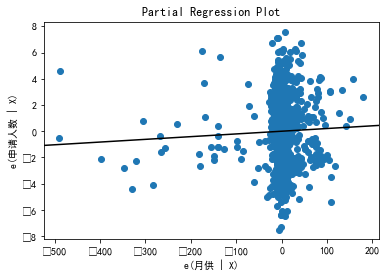

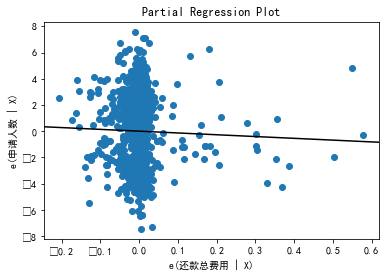

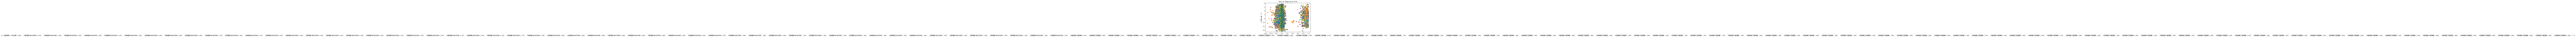

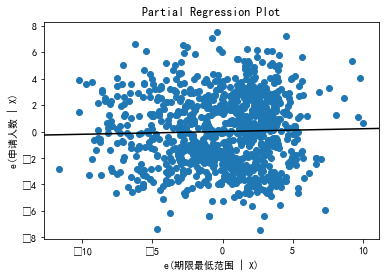

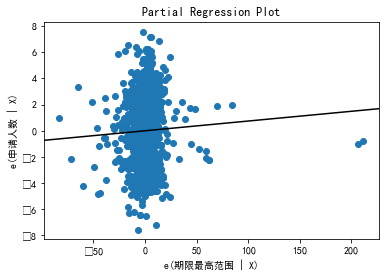

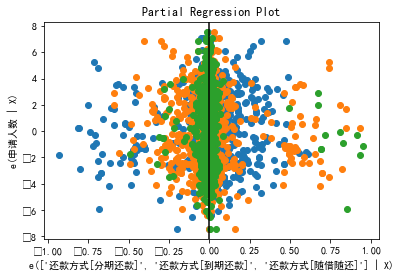

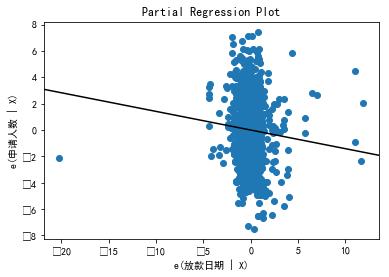

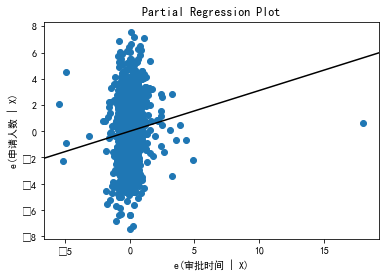

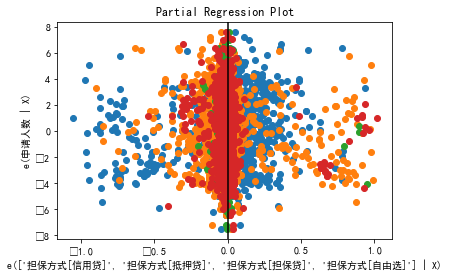

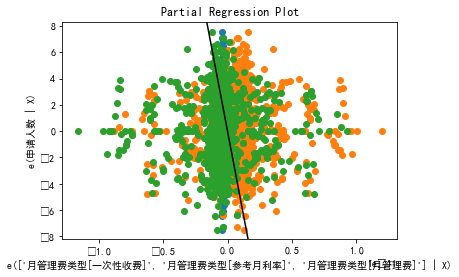

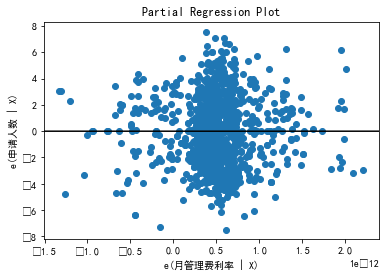

In [20]:
plot_names =['城市',
 '期限',
 '月供',
 '还款总费用',
 '月管理费',
 '期限最低范围',
 '期限最高范围',
 '还款方式',
 '放款日期',
 '审批时间',
 '担保方式',
 '月管理费类型',
 '月管理费利率']
# 绘制偏回归线观察数据点是否分布在估计得到的直线的附近
for i in range(len(plot_names)):
    plot_name = plot_names[:i] + plot_names[i + 1:]
    print(plot_names[i])
    sm.graphics.plot_partregress('申请人数', plot_names[i], plot_name, data = all_data, obs_labels = False)

    
#sm.graphics.plot_partregress('申请人数',  '担保方式', plot_name, data = all_data, obs_labels = False)


月供




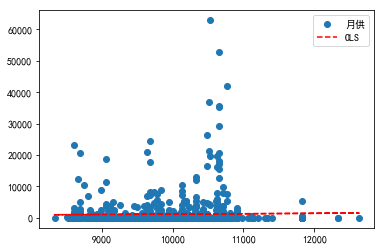

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.557
Model:                            OLS   Adj. R-squared:                -15.573
Method:                 Least Squares   F-statistic:                    -981.9
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:15   Log-Likelihood:                -10284.
No. Observations:                1046   AIC:                         2.057e+04
Df Residuals:                    1045   BIC:                         2.057e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1215      0.014      8.735      0.0

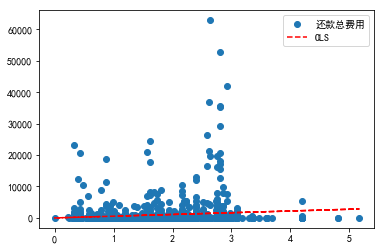

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.590
Model:                            OLS   Adj. R-squared:                -15.606
Method:                 Least Squares   F-statistic:                    -982.0
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:15   Log-Likelihood:                -10285.
No. Observations:                1046   AIC:                         2.057e+04
Df Residuals:                    1045   BIC:                         2.058e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           551.0033     64.031      8.605      0.0

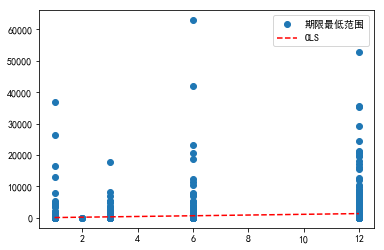

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.804
Model:                            OLS   Adj. R-squared:                -15.820
Method:                 Least Squares   F-statistic:                    -982.8
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:15   Log-Likelihood:                -10291.
No. Observations:                1046   AIC:                         2.058e+04
Df Residuals:                    1045   BIC:                         2.059e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           114.5653     14.814      7.734      0.0

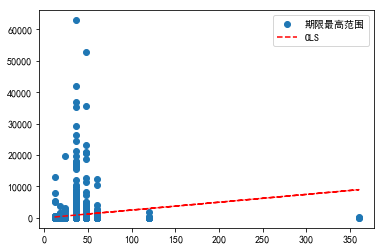

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.816
Model:                            OLS   Adj. R-squared:                -15.833
Method:                 Least Squares   F-statistic:                    -982.9
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:16   Log-Likelihood:                -10292.
No. Observations:                1046   AIC:                         2.059e+04
Df Residuals:                    1045   BIC:                         2.059e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            24.9626      3.249      7.682      0.0

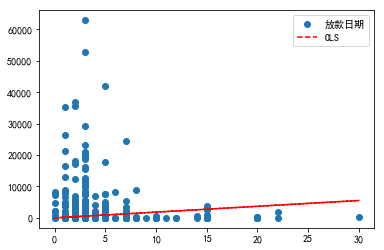

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -16.214
Model:                            OLS   Adj. R-squared:                -16.231
Method:                 Least Squares   F-statistic:                    -984.3
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:16   Log-Likelihood:                -10304.
No. Observations:                1046   AIC:                         2.061e+04
Df Residuals:                    1045   BIC:                         2.061e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           184.8343     31.936      5.788      0.0

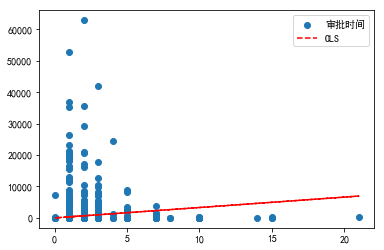

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -16.148
Model:                            OLS   Adj. R-squared:                -16.165
Method:                 Least Squares   F-statistic:                    -984.1
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:16   Log-Likelihood:                -10302.
No. Observations:                1046   AIC:                         2.061e+04
Df Residuals:                    1045   BIC:                         2.061e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           331.1308     53.962      6.136      0.0

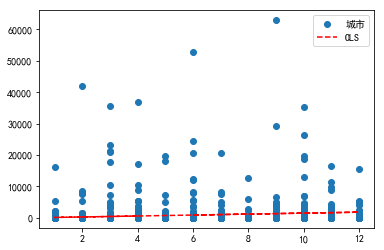

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.804
Model:                            OLS   Adj. R-squared:                -15.820
Method:                 Least Squares   F-statistic:                    -982.8
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:16   Log-Likelihood:                -10291.
No. Observations:                1046   AIC:                         2.058e+04
Df Residuals:                    1045   BIC:                         2.059e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           152.2293     19.682      7.735      0.0

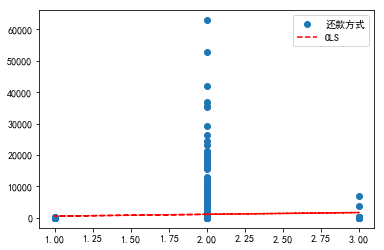

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.639
Model:                            OLS   Adj. R-squared:                -15.655
Method:                 Least Squares   F-statistic:                    -982.2
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:16   Log-Likelihood:                -10286.
No. Observations:                1046   AIC:                         2.057e+04
Df Residuals:                    1045   BIC:                         2.058e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           572.0499     67.980      8.415      0.0

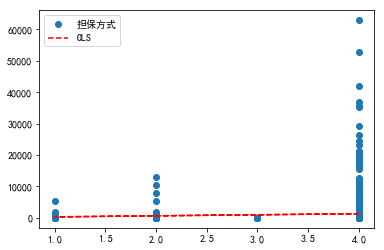

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.492
Model:                            OLS   Adj. R-squared:                -15.508
Method:                 Least Squares   F-statistic:                    -981.6
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:17   Log-Likelihood:                -10282.
No. Observations:                1046   AIC:                         2.057e+04
Df Residuals:                    1045   BIC:                         2.057e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           332.9736     37.059      8.985      0.0

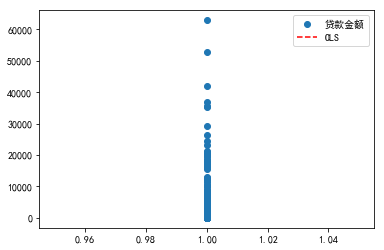

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Sun, 24 Nov 2019   Prob (F-statistic):                nan
Time:                        09:35:17   Log-Likelihood:                -10285.
No. Observations:                1046   AIC:                         2.057e+04
Df Residuals:                    1045   BIC:                         2.058e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1200.8719    139.421      8.613      0.0

C:\Users\WENDY\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


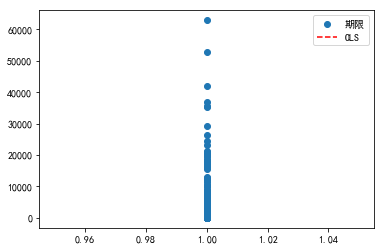

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       inf
Date:                Sun, 24 Nov 2019   Prob (F-statistic):                nan
Time:                        09:35:17   Log-Likelihood:                -10285.
No. Observations:                1046   AIC:                         2.057e+04
Df Residuals:                    1045   BIC:                         2.058e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1200.8719    139.421      8.613      0.0

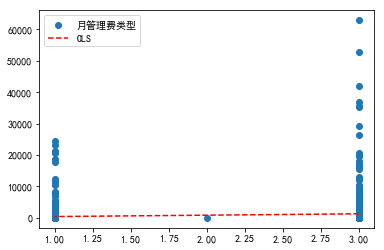

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.738
Model:                            OLS   Adj. R-squared:                -15.754
Method:                 Least Squares   F-statistic:                    -982.6
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:17   Log-Likelihood:                -10289.
No. Observations:                1046   AIC:                         2.058e+04
Df Residuals:                    1045   BIC:                         2.059e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           435.2064     54.319      8.012      0.0

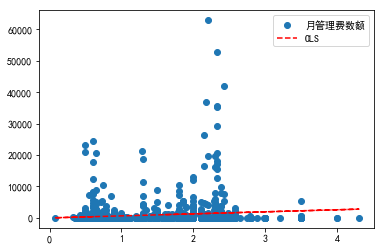

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     -15.658
Model:                            OLS   Adj. R-squared:                -15.674
Method:                 Least Squares   F-statistic:                    -982.3
Date:                Sun, 24 Nov 2019   Prob (F-statistic):               1.00
Time:                        09:35:17   Log-Likelihood:                -10287.
No. Observations:                1046   AIC:                         2.058e+04
Df Residuals:                    1045   BIC:                         2.058e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           648.3159     77.771      8.336      0.0

In [21]:
## 一个变量回归
y = all_results

for name in data.keys()[: -1]:
    print(name)
    print('\n')
    x = data[name].values.tolist()
    lm = sm.OLS(y, x).fit()
    
    ## 画出图像
    plt.plot(x, y, 'o', label = name)
    plt.plot(x, lm.fittedvalues, 'r--', label="OLS")
    plt.legend(loc='best')
    plt.show()
    
    print(lm.summary())
    print('\n\n\n')
    



In [31]:
all_results
x

[1.6,
 3.0,
 1.0,
 1.0,
 2.5,
 2.15,
 2.38,
 2.15,
 1.2,
 2.5,
 2.18,
 2.15,
 3.5,
 1.7,
 0.5,
 1.7,
 0.43,
 2.0,
 0.6,
 2.15,
 0.6,
 0.5,
 0.5,
 1.8,
 1.78,
 2.1,
 2.38,
 3.0,
 3.0,
 2.38,
 2.0,
 1.0,
 1.0,
 1.5,
 0.5,
 0.5,
 0.37,
 0.37,
 0.37,
 0.37,
 1.78,
 1.78,
 3.5,
 0.85,
 1.2,
 0.47,
 0.66,
 0.9,
 0.45,
 1.68,
 3.0,
 2.0,
 0.5,
 1.5,
 2.0,
 2.0,
 4.0,
 2.0,
 0.6,
 1.5,
 2.0,
 2.1,
 1.78,
 3.5,
 1.5,
 2.0,
 2.0,
 3.5,
 0.5,
 0.5,
 2.38,
 3.5,
 2.15,
 2.98,
 2.15,
 0.5,
 0.5,
 2.0,
 0.75,
 1.25,
 0.65,
 2.3,
 1.99,
 1.8,
 1.8,
 2.0,
 2.0,
 0.5,
 1.29,
 1.5,
 1.58,
 1.55,
 2.0,
 2.0,
 0.5,
 2.0,
 2.58,
 1.0,
 2.3,
 1.3,
 2.0,
 2.58,
 2.1,
 2.3,
 2.3,
 0.5,
 0.56,
 2.0,
 1.78,
 1.8,
 2.2,
 2.15,
 2.15,
 2.15,
 3.5,
 2.0,
 1.5,
 1.0,
 2.0,
 2.3,
 2.0,
 3.5,
 0.62,
 2.0,
 2.5,
 0.51,
 2.0,
 3.0,
 3.0,
 1.0,
 0.5,
 3.0,
 1.0,
 0.8,
 1.5,
 2.5,
 2.0,
 2.0,
 2.2,
 1.5,
 2.2,
 1.5,
 2.2,
 2.0,
 2.0,
 2.0,
 1.7,
 3.5,
 1.3,
 2.18,
 1.3,
 3.5,
 1.9,
 2.15,
 1.2,
 2.2,
 0.65,
 1.4,
 0.5,
 

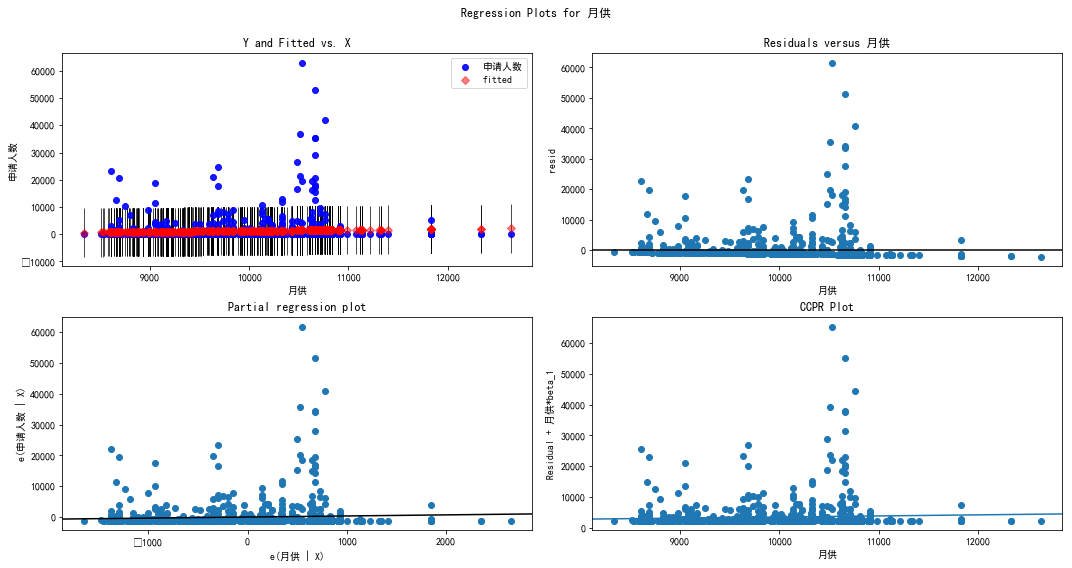

In [22]:
#训练模型
##一个自变量回归
one_lm = ols("""申请人数~ 月供""", data = data).fit()


fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(one_lm, "月供", fig =fig)

#fig.savefig('./simple linear regression plots.jpg',dpi=300) #保存图片


In [23]:
#训练模型
##多个自变量回归
###分训练集，测试集
####由于经常使用ML和DL的习惯，我习惯了先拆分数据集，后来发现其实线性回归不需要拆分数据集
####在计算指标的时候，直接使用train data即可
random.seed(123) #设立随机数种子
random_data = random.sample(range(len(data)), round(len(data)*0.2))
test_data=[]

for i in random_data:
    test_data.append(data.iloc[i])
    
test_data=pd.DataFrame(test_data)
train_data = data.drop(random_data)

#重新排列index
for i in [test_data, train_data]:
    i.index = range(i.shape[0])

print(train_data.head())
print(test_data.head())

      月供  还款总费用  期限最低范围  期限最高范围  放款日期  审批时间  城市  还款方式  担保方式  贷款金额  期限  月管理费类型  \
0  10046   2.06       1     120     1   1.0   6     3     2     1   1       3   
1   9333   1.20       1      36     3   1.0   6     2     4     1   1       1   
2   9749   1.70       1      36     1   1.0   6     2     2     1   1       3   
3  10483   2.58       1      36     3   2.0   6     2     4     1   1       3   
4  10713   2.86       1      12     1   1.0   6     2     2     1   1       3   

   月管理费数额  申请人数  
0    3.00    44  
1    1.00   308  
2    2.50     0  
3    2.15     0  
4    2.38  7821  
        月供  还款总费用  期限最低范围  期限最高范围  放款日期  审批时间    城市  还款方式  担保方式  贷款金额   期限  \
0  10333.0   2.40     1.0    36.0   0.0   1.0   1.0   2.0   4.0   1.0  1.0   
1  10913.0   3.10    12.0    36.0   3.0   2.0  11.0   2.0   4.0   1.0  1.0   
2   9763.0   1.72     3.0    60.0  20.0  15.0  11.0   2.0   4.0   1.0  1.0   
3  10723.0   2.87    12.0    24.0   3.0   2.0   8.0   2.0   4.0   1.0  1.0   
4   8662.0   0.

In [24]:
#训练模型
mul_lm = ols("""申请人数~ 月供 + 还款总费用 + 期限最低范围
                               + 期限最高范围 + 放款日期 + 审批时间 
                               + 城市 + 还款方式 + 担保方式 
                               + 月管理费类型 + 月管理费数额""",
                               data = data).fit()


In [25]:
mul_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   申请人数   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.500
Date:                Sun, 24 Nov 2019   Prob (F-statistic):              0.126
Time:                        09:35:27   Log-Likelihood:                -10276.
No. Observations:                1046   AIC:                         2.058e+04
Df Residuals:                    1034   BIC:                         2.064e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7769.0629   2.09e+04     -0.371      0.711   -4.89e+04    3.33e+04
月供             0.8639      2.508      0.344      0.731      -4.058       5.786
还款总费用       -563.0007   2118.076     -0.266      0.790   -4719.219    3593.218
期限最低范围       -18.5321     33.935     -0.546      0.585     -85.122      48.057
期限最高范围        13.5042      7.101      1.902      0.057      -0.430      27.438
放款日期        -129.7393     84.708     -1.532      0.126    -295.959      36.481
审批时间         106.6494    132.318      0.806      0.420    -152.993     366.291
城市            12.9559     41.630      0.311      0.756     -68.733      94.645
还款方式         -84.1007    607.190     -0.139      0.890   -1275.566    1107.364
担保方式         458.8789    200.334      2.291      0.022      65.772     851.986
月管理费类型      -381.2018    231.624     -1.646      0.100    -835.709      73.306
月管理费数额       423.3707    441.226      0.960      0.338    -442.429    1289.171
==============================================================================
Omnibus:                     1407.880   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           223824.034
Skew:                           7.379   Prob(JB):                         0.00
Kurtosis:                      73.127   Cond. No.                     1.52e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
#利用测试集测试模型
test_data.loc[:, "预计申请人数"] = mul_lm.predict(test_data)


In [27]:
#计算R方
##计算残差平方和
error2=[]
for i in range(len(test_data)):
    error2.append((test_data.loc[:, "预计申请人数"][i] - test_data.loc[:,"申请人数"][i])**2)

print(error2)

##计算总离差平方和
sst=[]
for i in range(len(test_data)):
    sst.append((test_data.loc[:,"预计申请人数"][i]-np.mean(test_data.loc[:,"申请人数"][i]))**2)
R2 = 1 - np.sum(error2) / np.sum(sst)


print("R方为:",R2)

[861106.5618818086, 1384400.1249339634, 1058777.306123406, 1749266.2361887298, 103521.73528876812, 2217388.4453120194, 3001.997620545906, 772228.490489198, 1166690.315386177, 236890.87973883172, 27000.723419862028, 1401220.9280379205, 2938720.271484408, 5003973.179920853, 1515683.3957629667, 114475721.89002384, 609936.0952404833, 410780.4993388254, 2838867.9012734937, 475303.51961379265, 1161114.9381541412, 1760.3534127288613, 21424.785000296808, 514.5637559092581, 10229055.125385776, 3323815.98338821, 3389809.997754968, 157394.83567624833, 3613667.653645607, 433823.8221076122, 509275.0420389079, 2024937.151416609, 132994.7320588233, 2750042.4055923377, 882882.2731627474, 1263498.0212970804, 4289.035792672562, 1209361.7234074916, 54147.94197486368, 902341.359180875, 3096445.5361379767, 1519357.761196701, 2507089.493126115, 3121360.5756132076, 1099470.1825129811, 60009728.12689271, 2225338.2896836377, 2671433.283571299, 4619.863037250156, 10970.818505167246, 2528078.5633676574, 3455995.

Text(0.5, 1.0, 'Predict and Real')

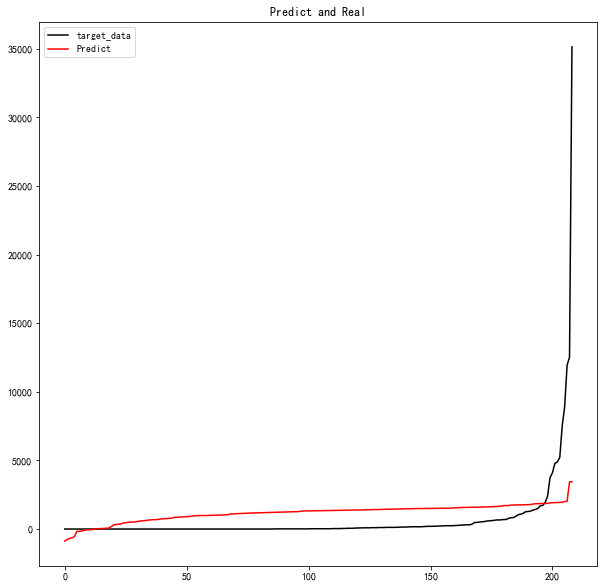

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(len(test_data.loc[:, "预计申请人数"])),sorted(test_data.loc[:,"申请人数"]),c="black",label= "target_data")
ax.plot(range(len(test_data.loc[:, "预计申请人数"])),sorted(test_data.loc[:, "预计申请人数"]),c="red",label = "Predict")
ax.legend(loc='best')
plt.title('Predict and Real')

In [29]:
# 创建停用词列表
def stopwordslist():
    path = 'C:\\Users\WENDY\\Desktop\\消费者行为分析\\课业2019\\stop_words.txt'
    stopwords = [line.strip() for line in open(path).readlines()]
    return stopwords

In [26]:
# 对句子进行中文分词
def seg_depart(sentence, seg_list):
    # 对文档中的每一行进行中文分词
    if type(sentence) == int:
        sentence = ''
#    sentence_depart = jieba.cut(sentence.strip())
    sentence_depart = []
    sentence = pseg.cut(sentence.strip())
    for word, flag in sentence:
        if flag in seg_list:
            sentence_depart.append(word)
            
    # 创建一个停用词列表
    stopwords = stopwordslist()
    # 输出结果为outstr
    outstr = []
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                # sqtj 1759, gsmc 384
                if len(word) != 1:
                    outstr.append(word)
    return outstr

In [27]:
def getTextDict(text_list, text_dict):
    for word in text_list:
        if word not in text_dict.keys():
            text_dict[word] = 1
        else:
            text_dict[word] = text_dict[word] + 1
    return text_dict

In [28]:
sqtj_dict = {}
gsmc_dict = {}
for row in all_data.itertuples(index = True, name = 'Pandas'):
    sqtj = getattr(row, '申请条件')
    sqtj_seg_list = ['n', 'a', 't', 'q']
    sqtj_list = seg_depart(sqtj, sqtj_seg_list)
    sqtj_dict = getTextDict(sqtj_list, sqtj_dict)
     
    gsmc = getattr(row, '公司名称')
    gsmc_seg_list = ['ns']
    gsmc_list = seg_depart(gsmc, gsmc_seg_list)
    gsmc_dict = getTextDict(gsmc_list, gsmc_dict)
    